In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import sciann as sn
import tensorflow.keras.callbacks as callbacks
from sciann.utils.math import diff
from sklearn.preprocessing import MinMaxScaler
import os
from sciann_datagenerator import DataGeneratorX
import tensorflow as tf

---------------------- SCIANN 0.6.3.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 


In [2]:
def data_tmp(start=0, end=1, num=1000, k=1, amp=1):
    dg = DataGeneratorX(
        X=[start, end],
        targets=["domain"],
        num_sample=num,
    )
    x = np.squeeze(dg.input_data[0])
    y_real = amp * np.cos(k * x)
    y_imag = amp * np.sin(k * x)  # complex valued part is phase shifted by 90°
    k_out = k * np.ones(y_real.shape)
    return x, y_real, y_imag, k_out

# NNs Method

In [3]:
x_data, p_real_data, p_imag_data, k_data = data_tmp(k=10)

# prepare data
"""
scaler = MinMaxScaler(feature_range=(-1, 1))
p_real_data = scaler.fit_transform(p_real_data.reshape(-1, 1))
p_imag_data = scaler.transform(p_imag_data.reshape(-1, 1))
"""
x = sn.Variable("x", dtype='float64')
k = sn.Variable("k_input", dtype='float64')

p_real = sn.Functional("p_real", [x, k], 8*[20], "tanh", res_net=True)
p_imag = sn.Functional("p_imag", [x, k], 8*[20], "tanh", res_net=True)

c1 = sn.Data(p_real)
c2 = sn.Data(p_imag)

model_nn = sn.SciModel([x, k], [c1, c2])

# callbacks
current_path = os.path.abspath('')
checkpoint_filepath = str(os.path.join(current_path,'callbacks/cp.ckpt'))
save_path = str(os.path.join(current_path,'model/G1d_WEIGHT.hdf5'))

model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='auto',
    save_best_only=True
)

history = model_nn.train(
    [x_data, k_data],
    [p_real_data, p_imag_data],
    epochs=500,
    batch_size=64,
    adaptive_weights={"method": "NTK", "freq": 100},
    callbacks=[model_checkpoint_callback]
)

# load the best performing model
model_nn.load_weights(checkpoint_filepath)



Total samples: 1000 
Batch size: 64 
Total batches: 16 

7.266235113143921

+ adaptive_weights at epoch 1: [1.6062687833919256, 0.3937312166080744]
Epoch 1/500
16/16 [==============================] - 2s 128ms/step - loss: 0.9202 - p_real_loss: 0.4327 - p_imag_loss: 0.5736
Epoch 2/500
16/16 [==============================] - 0s 11ms/step - loss: 0.6780 - p_real_loss: 0.3467 - p_imag_loss: 0.3078
Epoch 3/500
16/16 [==============================] - 0s 11ms/step - loss: 0.6380 - p_real_loss: 0.3237 - p_imag_loss: 0.2992
Epoch 4/500
16/16 [==============================] - 0s 11ms/step - loss: 0.6110 - p_real_loss: 0.3108 - p_imag_loss: 0.2836
Epoch 5/500
16/16 [==============================] - 0s 11ms/step - loss: 0.5858 - p_real_loss: 0.2956 - p_imag_loss: 0.2818
Epoch 6/500
16/16 [==============================] - 0s 11ms/step - loss: 0.5531 - p_real_loss: 0.2753 - p_imag_loss: 0.2807
Epoch 7/500
16/16 [==============================] - 0s 11ms/step - loss: 0.5208 - p_real_loss: 0.25

# PINNs methods

In [8]:
tf.keras.backend.clear_session()

x = sn.Variable("x", dtype='float64')
k = sn.Variable("k_input", dtype='float64')

p_real = sn.Functional("p_real", [x, k], 8*[20], "tanh", res_net=True)
p_imag = sn.Functional("p_imag", [x, k], 8*[20], "tanh", res_net=True)

# pde ($\Delta p + k^2 \cdot p = 0$) split into real- and complex-valued part
L1 = sn.rename(diff(p_real, x, order=2) + k**2 * p_real, 'PDE1')
L2 = sn.rename(diff(p_imag, x, order=2) + k**2 * p_imag, 'PDE2')
c1 = sn.Data(p_real)
c2 = sn.Data(p_imag)

model_pinn = sn.SciModel([x, k], [c1, c2, L1, L2])

# callbacks
current_path = os.path.abspath('')
checkpoint_filepath = str(os.path.join(current_path,'callbacks/cp.ckpt'))
save_path = str(os.path.join(current_path,'model/G1d_WEIGHT.hdf5'))

history2 = model_pinn.train(
    [x_data, k_data],
    [p_real_data, p_imag_data, 'zeros', 'zeros'],
    epochs=5000,
    batch_size=64,
    adaptive_weights={"method": "NTK", "freq": 100},
    callbacks=[model_checkpoint_callback])

# load the best performing model
model_pinn.load_weights(checkpoint_filepath)



Total samples: 1000 
Batch size: 64 
Total batches: 16 

72.92438459396362

+ adaptive_weights at epoch 1: [2.5221696304776478, 1.2774682169320934, 0.100242280478289, 0.10011987211196968]
Epoch 1/5000
16/16 [==============================] - 16s 979ms/step - loss: 2509.6234 - p_real_loss: 1.7449 - p_imag_loss: 2.3268 - PDE1_loss: 7610.4116 - PDE2_loss: 17521.2368
Epoch 2/5000
16/16 [==============================] - 1s 73ms/step - loss: 134.6437 - p_real_loss: 0.9389 - p_imag_loss: 0.3980 - PDE1_loss: 558.1386 - PDE2_loss: 757.6823
Epoch 3/5000
16/16 [==============================] - 1s 74ms/step - loss: 32.4609 - p_real_loss: 0.8080 - p_imag_loss: 0.3806 - PDE1_loss: 136.4394 - PDE2_loss: 162.2188
Epoch 4/5000
16/16 [==============================] - 1s 73ms/step - loss: 8.0057 - p_real_loss: 0.6889 - p_imag_loss: 0.3407 - PDE1_loss: 12.8241 - PDE2_loss: 45.4269
Epoch 5/5000
16/16 [==============================] - 1s 77ms/step - loss: 4.2529 - p_real_loss: 0.6630 - p_imag_loss: 0.3

KeyboardInterrupt: 

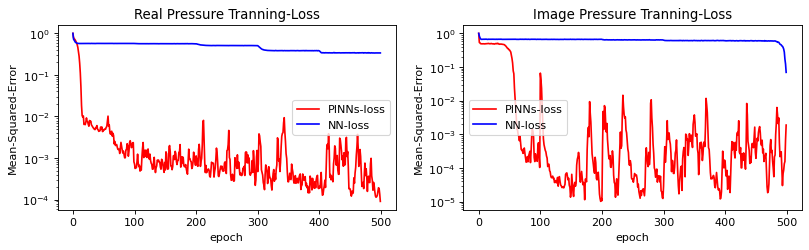

In [6]:
loss1 = history.history['p_real_loss'][0]
loss2 = history.history['p_imag_loss'][0]
loss3 = history2.history['p_real_loss'][0]
loss4 = history2.history['p_imag_loss'][0]
fig = plt.figure(1, figsize=(12, 3), dpi=80)
ax = plt.subplot(1, 2, 1)

plt.plot(history.history['p_real_loss'] / loss1, 'r', label='NNs-loss')
plt.plot(history2.history['p_real_loss'] / loss3, 'b', label='PINN-loss')
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('Mean-Squared-Error')
plt.title('Real Pressure Tranning-Loss')
plt.legend()

ax = plt.subplot(1, 2, 2)
plt.plot(history.history['p_imag_loss'] / loss2, 'r', label='NNs-loss')
plt.plot(history2.history['p_imag_loss'] / loss4, 'b', label='PINN-loss')
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('Mean-Squared-Error')
plt.title('Image Pressure Tranning-Loss')
plt.legend()
plt.show()   

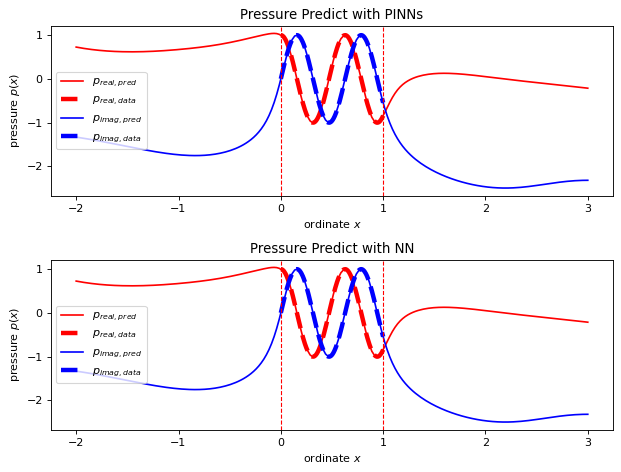

In [7]:
# predictions
x_pred = np.linspace(min(x_data)-2, max(x_data)+2, 200)
k_pred = k_data[0] * np.ones(x_pred.shape)
p_real_pred = p_real.eval(model_pinn, [x_pred, k_pred])
p_imag_pred = p_imag.eval(model_pinn, [x_pred, k_pred])

# sort data for plotting
p_real_data = p_real_data[x_data.argsort()]
p_imag_data = p_imag_data[x_data.argsort()]
x_data = x_data[x_data.argsort()]

# plot
fig = plt.figure(2, figsize=(8, 6), dpi=80)
ax = plt.subplot(2, 1, 1)
# pressure
plt.plot(x_pred, p_real_pred, 'r', label='$p_{real, pred}$')
plt.plot(x_data, p_real_data, 'r--', lw=4, label='$p_{real, data}$')
plt.plot(x_pred, p_imag_pred, 'b', label='$p_{imag, pred}$')
plt.plot(x_data, p_imag_data, 'b--', lw=4, label='$p_{imag, data}$')
ax.set_xlabel('ordinate $x$')
ax.set_ylabel('pressure $p(x)$')
ax.set_title('Pressure Predict with PINNs')
ax.legend()
plt.axvline(0, linewidth=1, linestyle='--', color='red')
plt.axvline(1, linewidth=1, linestyle='--', color='red')
plt.tight_layout()


# predictions
p_real_pred = p_real.eval(model_nn, [x_pred, k_pred])
p_imag_pred = p_imag.eval(model_nn, [x_pred, k_pred])

# sort data for plotting
p_real_data = p_real_data[x_data.argsort()]
p_imag_data = p_imag_data[x_data.argsort()]
x_data = x_data[x_data.argsort()]

# plot
ax = plt.subplot(2, 1, 2)
# pressure
plt.plot(x_pred, p_real_pred, 'r', label='$p_{real, pred}$')
plt.plot(x_data, p_real_data, 'r--', lw=4, label='$p_{real, data}$')
plt.plot(x_pred, p_imag_pred, 'b', label='$p_{imag, pred}$')
plt.plot(x_data, p_imag_data, 'b--', lw=4, label='$p_{imag, data}$')
ax.set_xlabel('ordinate $x$')
ax.set_ylabel('pressure $p(x)$')
ax.set_title('Pressure Predict with NN')
ax.legend()
# plt.axhline(1, linewidth=1, linestyle='-', color='red')
plt.axvline(0, linewidth=1, linestyle='--', color='red')
plt.axvline(1, linewidth=1, linestyle='--', color='red')
plt.tight_layout()

plt.show()